

## **Necessities & Requirements**



In [ ]:
import librosa
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, MaxPooling2D, Flatten, Input, concatenate
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
pd.set_option('display.precision', 10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Handle Regions**

In [ ]:
def get_cords():
    # Define the field dimensions in centimeters
    field_width = 280  # in cm
    field_height = 400  # in cm

    # Define the point spacing in centimeters
    point_spacing = 20  # in cm

    # Define the table's properties
    table_z = 75  # height of the table in cm
    table_x_min = 70  # x coordinate of the left edge of the table
    table_x_max = 210  # x coordinate of the right edge of the table
    table_y_min = 330  # y coordinate of the top edge of the table
    table_y_max = 400  # y coordinate of the bottom edge of the table

    # Calculate the number of points along each axis
    num_points_x = field_width // point_spacing + 1
    num_points_y = field_height // point_spacing + 1

    # Generate the points
    points = []
    index = 0

    for y in range(int(num_points_y)):
        for x in range(int(num_points_x)):
            point_x = x * point_spacing
            point_y = y * point_spacing

            # Check if the point is within the table's footprint
            if table_x_min <= point_x <= table_x_max and table_y_min <= point_y <= table_y_max:
                point_z = table_z  # Points on the table have z-coordinate 75
            else:
                point_z = 0  # Points on the ground have z-coordinate 0

            points.append({str(index): (point_x, point_y, point_z)})
            index += 1
    return points

In [ ]:
def find_first_greater(cand, vals):
    for val in vals:
        start, end = val
        if cand >= start and cand <= end:
            return vals.index(val)

def categorize_ordinary_samples(coors, x_regions, y_regions, y_lim=220):
    region_dict = {}
    for i in range(20):
        region_dict[i] = []
    for cor in coors:
        if cor[1] <= y_lim:
            x, y, z = cor
            x_idx = find_first_greater(x, x_regions)
            y_idx = find_first_greater(y, y_regions) + 1
            region = x_idx + len(x_regions) * (y_idx - 1)
            region_dict[region].append(cor)
    return region_dict

def categorize_conditioned_samples(coors, region_dict, start_cnt=12, start_cor=(0, 240, 0)):
    info_dict = {
        12: [(0,70), (235,330)],
        13: [(70,  145), (235, 330)],
        14: [(145, 210), (235, 330)],
        15: [(210, 282), (235, 330)],
        16: [(0, 70), (330, 400)],
        17: [(70, 145), (330, 400)],
        18: [(145, 210), (330, 400)],
        19: [(210, 282), (330, 400)],
    }
    start_idx = coors.index(start_cor)
    for i in range(start_idx, len(coors)):
        x, y, z = coors[i]
        for key, [x_region, y_region] in info_dict.items():
            strat_x, end_x = x_region
            strat_y, end_y = y_region
            if x >= strat_x and x <= end_x and y >= strat_y and y <= end_y:
                region_dict[key].append(coors[i])
    return region_dict

tot_coords = get_cords()
coordinates = [list(cor.values())[0] for cor in tot_coords]
x_regions = [(0, 75), (75, 155), (155, 235), (235, 282)]
y_regions = [(0, 75), (75, 155), (155, 235)]
regions_dict = categorize_ordinary_samples(coordinates, x_regions, y_regions)
regions_dict = categorize_conditioned_samples(coordinates, regions_dict)
print(*zip(regions_dict.keys(), [len(val) for val in regions_dict.values()]), sep='\n')
print(*regions_dict.items(), sep='\n\n')

sum = 0
for val in regions_dict.values():
    sum += len(val)
print('Total Number of Categorized Samples:', sum)

(0, 16)
(1, 16)
(2, 16)
(3, 12)
(4, 16)
(5, 16)
(6, 16)
(7, 12)
(8, 16)
(9, 16)
(10, 16)
(11, 12)
(12, 20)
(13, 20)
(14, 15)
(15, 20)
(16, 16)
(17, 16)
(18, 12)
(19, 16)
(0, [(0, 0, 0), (20, 0, 0), (40, 0, 0), (60, 0, 0), (0, 20, 0), (20, 20, 0), (40, 20, 0), (60, 20, 0), (0, 40, 0), (20, 40, 0), (40, 40, 0), (60, 40, 0), (0, 60, 0), (20, 60, 0), (40, 60, 0), (60, 60, 0)])

(1, [(80, 0, 0), (100, 0, 0), (120, 0, 0), (140, 0, 0), (80, 20, 0), (100, 20, 0), (120, 20, 0), (140, 20, 0), (80, 40, 0), (100, 40, 0), (120, 40, 0), (140, 40, 0), (80, 60, 0), (100, 60, 0), (120, 60, 0), (140, 60, 0)])

(2, [(160, 0, 0), (180, 0, 0), (200, 0, 0), (220, 0, 0), (160, 20, 0), (180, 20, 0), (200, 20, 0), (220, 20, 0), (160, 40, 0), (180, 40, 0), (200, 40, 0), (220, 40, 0), (160, 60, 0), (180, 60, 0), (200, 60, 0), (220, 60, 0)])

(3, [(240, 0, 0), (260, 0, 0), (280, 0, 0), (240, 20, 0), (260, 20, 0), (280, 20, 0), (240, 40, 0), (260, 40, 0), (280, 40, 0), (240, 60, 0), (260, 60, 0), (280, 60, 0)])

(

## **Load Spectrums**

### **Power Spectrums**

In [ ]:
path = '/content/drive/MyDrive/SSL/'
with open(path + 'power_spectrums_k2.pkl', 'rb') as file:
    power_spectrums_k2 = pickle.load(file)
with open(path + 'power_spectrums_k3.pkl', 'rb') as file:
    power_spectrums_k3 = pickle.load(file)
with open(path + 'labels.pkl', 'rb') as file:
    coors = pickle.load(file)

print(power_spectrums_k2.shape, power_spectrums_k3.shape)
print(coors)

KeyboardInterrupt: 

In [ ]:
# Compute the energy of each channel for weighting
kinect2_energy = np.sum(power_spectrums_k2, axis=(2, 3))  # Shape: (315, 4)
kinect3_energy = np.sum(power_spectrums_k3, axis=(2, 3))  # Shape: (315, 4)

# Normalize the energy to get the weights
kinect2_weights = kinect2_energy / np.sum(kinect2_energy, axis=1, keepdims=True)
kinect3_weights = kinect3_energy / np.sum(kinect3_energy, axis=1, keepdims=True)

# Multiply each channel by its respective weight and then sum
kinect2_weighted_avg = np.sum(power_spectrums_k2 * kinect2_weights[:, :, np.newaxis, np.newaxis], axis=1)
kinect3_weighted_avg = np.sum(power_spectrums_k3 * kinect3_weights[:, :, np.newaxis, np.newaxis], axis=1)

print(kinect2_weighted_avg.shape)
print(kinect3_weighted_avg.shape)

(315, 401, 722)
(315, 401, 722)


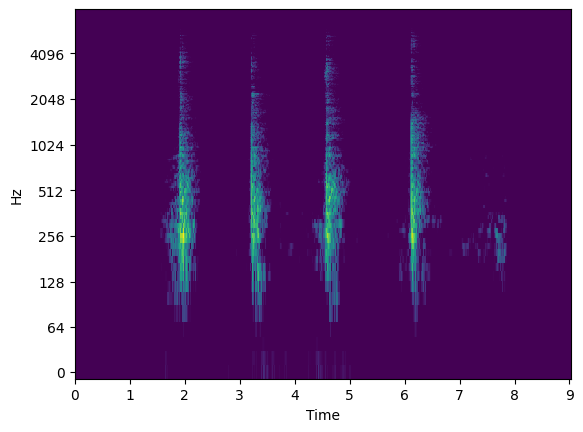

In [ ]:
librosa.display.specshow(kinect3_weighted_avg[211], sr=16000, hop_length=200, x_axis='time', y_axis='log', cmap='viridis')
plt.show()

In [ ]:
final_spectra = np.stack((kinect2_weighted_avg, kinect3_weighted_avg), axis=1)
print(final_spectra.shape)

(315, 2, 401, 722)


### **Load Phase Spectrum**

In [ ]:
with open(path + 'phase_spectrums_k2.pkl', 'rb') as file:
    phase_spectrums_k2 = pickle.load(file)
with open(path + 'phase_spectrums_k3.pkl', 'rb') as file:
    phase_spectrums_k3 = pickle.load(file)
with open(path + 'labels.pkl', 'rb') as file:
    coors = pickle.load(file)

print(phase_spectrums_k2.shape, phase_spectrums_k3.shape)
print(coors)

(315, 401, 722) (315, 401, 722)
[(0, 0, 0), (20, 0, 0), (40, 0, 0), (60, 0, 0), (80, 0, 0), (100, 0, 0), (120, 0, 0), (140, 0, 0), (160, 0, 0), (180, 0, 0), (200, 0, 0), (220, 0, 0), (240, 0, 0), (260, 0, 0), (280, 0, 0), (0, 20, 0), (20, 20, 0), (40, 20, 0), (60, 20, 0), (80, 20, 0), (100, 20, 0), (120, 20, 0), (140, 20, 0), (160, 20, 0), (180, 20, 0), (200, 20, 0), (220, 20, 0), (240, 20, 0), (260, 20, 0), (280, 20, 0), (0, 40, 0), (20, 40, 0), (40, 40, 0), (60, 40, 0), (80, 40, 0), (100, 40, 0), (120, 40, 0), (140, 40, 0), (160, 40, 0), (180, 40, 0), (200, 40, 0), (220, 40, 0), (240, 40, 0), (260, 40, 0), (280, 40, 0), (0, 60, 0), (20, 60, 0), (40, 60, 0), (60, 60, 0), (80, 60, 0), (100, 60, 0), (120, 60, 0), (140, 60, 0), (160, 60, 0), (180, 60, 0), (200, 60, 0), (220, 60, 0), (240, 60, 0), (260, 60, 0), (280, 60, 0), (0, 80, 0), (20, 80, 0), (40, 80, 0), (60, 80, 0), (80, 80, 0), (100, 80, 0), (120, 80, 0), (140, 80, 0), (160, 80, 0), (180, 80, 0), (200, 80, 0), (220, 80, 0), (240

In [ ]:
final_phase = np.stack((phase_spectrums_k2, phase_spectrums_k3), axis=1)
print(final_phase.shape)

(315, 2, 401, 722)


## **Load TDOA**

In [ ]:
# load TDOAs
with open('/content/drive/MyDrive/SSL/denoised_tdoa_df_int20.pkl', 'rb') as file:
    tdoa_df = pickle.load(file)

tdoa_df = tdoa_df.iloc[:, :].drop(['label'], axis=1)
print(tdoa_df.columns, tdoa_df.shape)

Index(['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1', 'tdoa13_k1',
       'tdoa23_k1', 'tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2',
       'tdoa13_k2', 'tdoa23_k2', 'tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3',
       'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3'],
      dtype='object') (315, 18)


## **Load Raw Samples**

In [ ]:
with open('/content/drive/MyDrive/Taarlab/Classical/Main/3kinects/Raw Samples/denoised_samples_dict.pkl', 'rb') as file:
    raw_samples_dict = pickle.load(file)

In [ ]:
for key, val in raw_samples_dict.items():
    raw_samples_dict[key] = np.array(val)

In [ ]:
k2_samples = np.array([val[1] for val in raw_samples_dict.values()])
k3_samples = np.array([val[2] for val in raw_samples_dict.values()])
print(k2_samples.shape)
print(k3_samples.shape)

(315, 4, 145000)
(315, 4, 145000)


In [ ]:
k2_3_stacked = np.stack((k2_samples, k3_samples), axis=-1)
print(k2_3_stacked.shape)

(315, 4, 145000, 2)


## **Prepare Data**

In [ ]:
def get_test_coors(test_coors_x, test_coors_y):
    test_coors_z = []
    for x, y in zip(test_coors_x, test_coors_y):
        if y >= 330 and x >= 70 and x <= 210:
            test_coors_z.append(75)
        else:
            test_coors_z.append(0)
    test_coors = [(x, y, z) for x, y, z in zip(test_coors_x, test_coors_y, test_coors_z)]
    return test_coors

In [ ]:
# determine test
test_coors_x = [0, 200, 100, 280, 40, 160, 80, 220, 20, 160, 120, 260, 60, 240, 180, 100, 280, 40, 260, 80, 220, 0, 140, 180, 20]
test_coors_y = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 340, 360, 380, 400]
# test_coors_x = [0, 200, 100, 280, 160, 80, 20, 160, 120, 260, 60, 240, 100, 280, 40, 80, 220, 0, 180, 20]
# test_coors_y = [0, 20, 40, 60, 100, 120, 160, 180, 200, 220, 240, 260, 300, 320, 340, 380, 400, 340, 380, 400]
test_coors = get_test_coors(test_coors_x, test_coors_y)
# determine train
tot_coords = get_cords()
coordinates = [list(cor.values())[0] for cor in tot_coords]
train_coors = [cor for cor in coordinates if cor not in test_coors]

In [ ]:
print('Number of Train coords:', len(train_coors))
print('Number of Test coords:', len(test_coors))

Number of Train coords: 290
Number of Test coords: 25


In [ ]:
def sort_coors_and_regions(regions_dict, coordinates):
    regions = []
    for cor in coordinates:
        for key, val in regions_dict.items():
            if cor in val:
                regions.append(key)
                break
    return np.array(regions)

### **Two-Branched Network samples**

In [ ]:
k1_measured_tdoas = tdoa_df[['tdoa01_k1', 'tdoa02_k1', 'tdoa03_k1', 'tdoa12_k1','tdoa13_k1', 'tdoa23_k1']].to_numpy()
d = k1_measured_tdoas
k1_measured_tdoas = (d - np.min(d)) / (np.max(d) - np.min(d))
k2_measured_tdoas = tdoa_df[['tdoa01_k2', 'tdoa02_k2', 'tdoa03_k2', 'tdoa12_k2','tdoa13_k2', 'tdoa23_k2']].to_numpy()
d = k2_measured_tdoas
k2_measured_tdoas = (d - np.min(d)) / (np.max(d) - np.min(d))
k3_measured_tdoas = tdoa_df[['tdoa01_k3', 'tdoa02_k3', 'tdoa03_k3', 'tdoa12_k3', 'tdoa13_k3', 'tdoa23_k3']].to_numpy()
d = k3_measured_tdoas
k3_measured_tdoas = (d - np.min(d)) / (np.max(d) - np.min(d))

In [ ]:
print(k3_measured_tdoas)

[[0.18610422 0.08188586 0.         0.41935484 0.32009926 0.50620347]
 [0.18362283 0.09677419 0.00992556 0.42679901 0.34243176 0.43424318]
 [0.19851117 0.1191067  0.01240695 0.43920596 0.34491315 0.44665012]
 ...
 [0.63771712 0.76923077 0.80397022 0.53598015 0.55831266 0.53101737]
 [0.59305211 0.63771712 0.67741935 0.55086849 0.5955335  0.54094293]
 [0.61538462 0.60049628 0.62779156 0.55831266 0.61042184 0.54590571]]


In [ ]:
print(k2_measured_tdoas.shape)
print(k3_measured_tdoas.shape)
print(k1_measured_tdoas.shape)

(315, 6)
(315, 6)
(315, 6)


In [ ]:
# prepare input and target
# final_spectra = np.transpose(final_spectra, (0, 2, 3, 1))
# X_df_spectrum = final_spectra
# X_df_phase = final_phase
# X_df_phase = np.transpose(final_phase, (0, 2, 3, 1))
# X_df_tdoa = np.hstack((k2_measured_tdoas, k3_measured_tdoas))

# normalize tdoa data
# arr_min = np.min(X_df_tdoa, axis=0)
# arr_max = np.max(X_df_tdoa, axis=0)
# # Apply min-max normalization
# norm_X_df_tdoa = (X_df_tdoa - arr_min) / (arr_max - arr_min)

# targets
y_df = sort_coors_and_regions(regions_dict, coordinates)
y_df = to_categorical(y_df, num_classes=20)

# get test index and split train and test
test_indexes = [coordinates.index(cor) for cor in test_coors]
train_indexes = [coordinates.index(cor) for cor in train_coors]

# X_test_CNN_power = np.array([X_df_spectrum[i] for i in test_indexes])
# X_test_CNN_phase = np.array([X_df_phase[i] for i in test_indexes])
X_test_MLP_k2 = np.array([k2_measured_tdoas[i] for i in test_indexes])
X_test_MLP_k3 = np.array([k3_measured_tdoas[i] for i in test_indexes])
X_test_MLP_k1 = np.array([k1_measured_tdoas[i] for i in test_indexes])
y_test = np.array([y_df[i] for i in test_indexes])

# X_train_CNN_power = np.array([X_df_spectrum[i] for i in train_indexes])
# X_train_CNN_phase = np.array([X_df_phase[i] for i in train_indexes])
X_train_MLP_k2 = np.array([k2_measured_tdoas[i] for i in train_indexes])
X_train_MLP_k3 = np.array([k3_measured_tdoas[i] for i in train_indexes])
X_train_MLP_k1 = np.array([k1_measured_tdoas[i] for i in train_indexes])
y_train = np.array([y_df[i] for i in train_indexes])

print(X_train_MLP_k2.shape, X_train_MLP_k3.shape, y_train.shape)
print(X_test_MLP_k3.shape, X_test_MLP_k3.shape, y_test.shape)

(290, 6) (290, 6) (290, 20)
(25, 6) (25, 6) (25, 20)


### **End2End CNN**

In [ ]:
X_df = k2_3_stacked

# Normalize the values to the range [0, 1]
min_val = np.min(X_df)
max_val = np.max(X_df)
X_df = (X_df - min_val) / (max_val - min_val)

# targets
y_df = sort_coors_and_regions(regions_dict, coordinates)
y_df = to_categorical(y_df, num_classes=20)

# get test index and split train and test
test_indexes = [coordinates.index(cor) for cor in test_coors]
train_indexes = [coordinates.index(cor) for cor in train_coors]
X_test = np.array([X_df[i] for i in test_indexes])
y_test = np.array([y_df[i] for i in test_indexes])
X_train = np.array([X_df[i] for i in train_indexes])
y_train = np.array([y_df[i] for i in train_indexes])
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

NameError: name 'k2_3_stacked' is not defined

### **Random Forest Classification Dala**

In [ ]:
# tdoa input data
X_df = tdoa_df
# normalize tdoa data
arr_min = np.min(X_df, axis=0)
arr_max = np.max(X_df, axis=0)
# Apply min-max normalization
norm_X_df_tdoa = (X_df - arr_min) / (arr_max - arr_min)
# targets
y_df = sort_coors_and_regions(regions_dict, coordinates)
y_df = to_categorical(y_df, num_classes=20)

# split data
test_indexes = [coordinates.index(cor) for cor in test_coors]
train_indexes = [coordinates.index(cor) for cor in train_coors]
X_train = np.array([norm_X_df_tdoa.iloc[i] for i in train_indexes])
y_train = np.array([y_df[i] for i in train_indexes])
X_test = np.array([norm_X_df_tdoa.iloc[i] for i in test_indexes])
y_test = np.array([y_df[i] for i in test_indexes])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_df.shape, norm_X_df_tdoa.shape)

(290, 18) (290, 20)
(25, 18) (25, 20)
(315, 20) (315, 18)


## **Classification models**

### **DNN**

In [ ]:
def get_model(inp_shape_CNN, inp_shape_MLP):

    '''Two Branched CNN'''
    # model = tf.keras.Sequential([
    #     # CNN based
    #     # First block
    #     tf.keras.layers.Conv2D(64, (7, 7), activation='relu', input_shape=inp_shape),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling2D((7, 7)),
    #     # Second Block
    #     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling2D((1, 8)),
    #     # Third Block
    #     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling2D((1, 8)),
    #     # Flatten followed by dense layers
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(256, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(20, activation='softmax'),
    # )]

        # # MLP Based
        # tf.keras.layers.Dense(256, activation='relu', input_shape=inp_shape),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dense(128, activation='relu', input_shape=inp_shape),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(96, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(70, activation='softmax'),
        # # tf.keras.layers.Dense(70, activation='softmax'),

    # # Branch 1: Conv2D Layers
    # input_branch1 = Input(shape=(inp_shape_CNN))
    # x1 = Conv2D(64, (7, 7), activation='relu')(input_branch1)
    # x1 = BatchNormalization()(x1)
    # x1 = MaxPooling2D(pool_size=(7, 7))(x1)
    # # second layer
    # x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    # x1 = BatchNormalization()(x1)
    # x1 = MaxPooling2D(pool_size=(1, 8))(x1)
    # # third layer
    # x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    # x1 = BatchNormalization()(x1)
    # x1 = MaxPooling2D(pool_size=(1, 8))(x1)
    # # Flatten for concatenation later
    # x1 = Flatten()(x1)

    # # Branch 2 (MLP):
    # input_branch2 = Input(shape=inp_shape_MLP)
    # x2 = Dense(64, activation='relu')(input_branch2)
    # x2 = BatchNormalization()(x2)
    # x2 = Dropout(0.5)(x2)
    # x2 = Dense(32, activation='relu')(x2)
    # x2 = BatchNormalization()(x2)
    # x2 = Dropout(0.5)(x2)
    # # Flatten the MLP output for concatenation
    # # x2 = Flatten()(x2)

    # # Branch 3 (MLP):
    # input_branch3 = Input(shape=inp_shape_MLP)
    # x3 = Dense(64, activation='relu')(input_branch3)
    # x3 = BatchNormalization()(x3)
    # x3 = Dropout(0.5)(x3)
    # x3 = Dense(32, activation='relu')(x3)
    # x3 = BatchNormalization()(x3)
    # x3 = Dropout(0.5)(x3)
    # # Flatten the MLP output for concatenation
    # # x3 = Flatten()(x3)

    # # Concatenate the two MLP branches
    # mlp_concat = concatenate([x2, x3])

    # # Concatenate the output of the MLP branches with the CNN branch
    # final_concat = concatenate([x1, mlp_concat])

    # # Final Dense layers
    # x = Dense(256, activation='relu')(final_concat)
    # x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    # x = Dense(20, activation='softmax')(x)

    # # Create the model
    # model = Model(inputs=[input_branch1, input_branch2, input_branch3], outputs=x)

    # # Compile the model
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # # Model summary (optional, for debugging)
    # model.summary()


    '''E2E CNN model'''
    # # E2E model
    # model = Sequential()
    # # First Layer
    # model.add(Conv2D(128, (1, 10), activation='relu', input_shape=inp_shape, strides=(1,5)))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((1, 10)))
    # # Second Layer
    # model.add(Conv2D(64, (1, 7), activation='relu', input_shape=inp_shape, strides=(1, 2)))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((1, 7)))
    # # Fourth Layer
    # model.add(Conv2D(64, (1, 5), activation='relu', input_shape=inp_shape))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((1, 5)))
    # # Fifth Layer
    # model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inp_shape))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((1, 3)))
    # # Flatten layer
    # model.add(Flatten())
    # # First Dense layer
    # model.add(Dense(256, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    # # Output layer
    # model.add(Dense(20, activation='softmax'))

    # Define the input for the first branch
    input1 = Input(shape=(6,))
    x1 = Dense(64, activation='relu')(input1)
    x1 = BatchNormalization()(x1)
    x1 = Dense(32, activation='relu')(x1)
    x1 = BatchNormalization()(x1)

    # Define the input for the first branch
    input2 = Input(shape=(6,))
    x2 = Dense(64, activation='relu')(input2)
    x2 = BatchNormalization()(x2)
    x2 = Dense(32, activation='relu')(x2)
    x2 = BatchNormalization()(x2)

    # Define the input for the first branch
    input3 = Input(shape=(6,))
    x3 = Dense(64, activation='relu')(input3)
    x3 = BatchNormalization()(x3)
    x3 = Dense(32, activation='relu')(x3)
    x3 = BatchNormalization()(x3)

    # Concatenate the outputs of the two branches
    concatenated = concatenate([x1, x2, x3])

    # Add a final dense layer
    x = Dense(128, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    # x = Dropout(0.4)(x)
    final_output = Dense(20, activation='softmax')(x)

    # Define the model
    model = Model(inputs=[input1, input2, input3], outputs=final_output)

    # # Create the model
    # model = Model(inputs=[input_branch1, input_branch2], outputs=x)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
csl_model = get_model(None, None)
csl_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_23            │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_58 (Dense)          │ (None, 64)             │            448 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 64)             │            448 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_62 (Dense)          │ (None, 64)             │            448 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 64)             │            256 │ dense_58[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 64)             │            256 │ dense_60[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_53    │ (None, 64)             │            256 │ dense_62[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_59 (Dense)          │ (None, 32)             │          2,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_61 (Dense)          │ (None, 32)             │          2,080 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_63 (Dense)          │ (None, 32)             │          2,080 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 32)             │            128 │ dense_59[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_52    │ (None, 32)             │            128 │ dense_61[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 32)             │            128 │ dense_63[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 24,244 (94.70 KB)

 Trainable params: 23,412 (91.45 KB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
es = EarlyStopping(
    monitor='loss',
    mode='min',
    verbose=1,
    patience=50,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=1e-6)

# csl_model.optimizer.learning_rate = 1.0000e-04

csl_hist = csl_model.fit([X_train_MLP_k1, X_train_MLP_k2, X_train_MLP_k3], y_train, epochs=200, validation_split=0.1, batch_size=16, callbacks=[es, reduce_lr])

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.1675 - loss: 2.8537 - val_accuracy: 0.0000e+00 - val_loss: 3.0266 - learning_rate: 0.0010
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4870 - loss: 1.5553 - val_accuracy: 0.0000e+00 - val_loss: 3.0951 - learning_rate: 0.0010
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5499 - loss: 1.3253 - val_accuracy: 0.0000e+00 - val_loss: 3.1692 - learning_rate: 0.0010
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6108 - loss: 1.1519 - val_accuracy: 0.0000e+00 - val_loss: 3.3048 - learning_rate: 0.0010
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6477 - loss: 1.0329 - val_accuracy: 0.0000e+00 - val_loss: 3.4057 - learning_rate: 0.0010
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7037 - loss: 0.9178 - val_accuracy: 0.0000e+00 - val_loss: 3.5352 - learning_rate: 0.0010
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6887

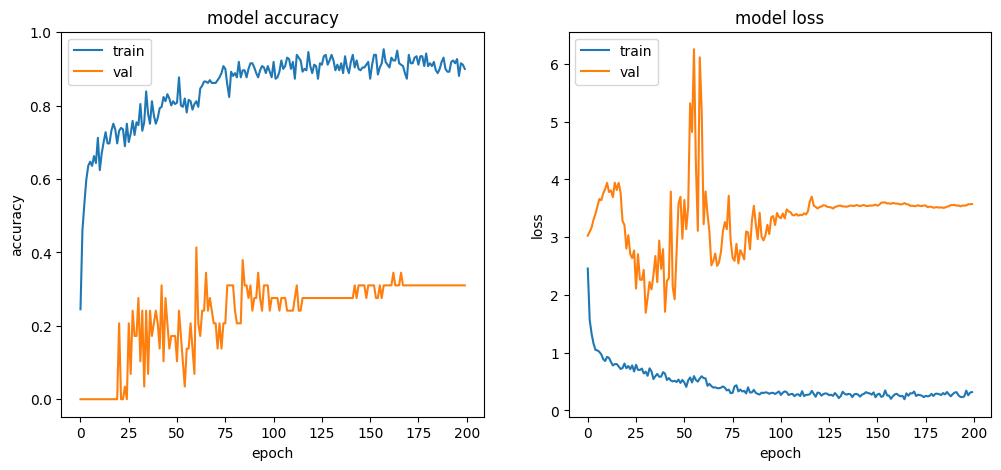

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(csl_hist.history['accuracy'], label='train')
axes[0].plot(csl_hist.history['val_accuracy'], label='val')
axes[0].set_title('model accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].legend(loc='upper left')
axes[1].plot(csl_hist.history['loss'], label='train')
axes[1].plot(csl_hist.history['val_loss'], label='val')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(loc='upper left')
plt.show()

In [ ]:
csl_model.save('csl_2branchcnn_model.keras')

NameError: name 'csl_model' is not defined

In [ ]:
csl_model = keras.saving.load_model('csl_2branchcnn_model.keras')

In [ ]:
test_loss, test_accuracy = csl_model.evaluate([X_test_MLP_k1,X_test_MLP_k2, X_test_MLP_k3], y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6400 - loss: 1.2931
Test Accuracy: 64.00%


In [ ]:
preds = csl_model.predict([X_test_MLP_k1, X_test_MLP_k2, X_test_MLP_k3])
preds_rev = np.argmax(preds, axis=1)
y_test_rev = np.argmax(y_test, axis=1)
regions_pred = {}
for i in range(len(test_coors)):
    regions_pred[test_coors[i]] = preds_rev[i]
    print(test_coors[i], '->', 'Pred:', preds_rev[i], 'Actual:', y_test_rev[i])

# Save dicti?onary
with open('/content/drive/MyDrive/SSL/3branch_mlp.pkl', 'wb') as file:
    pickle.dump(regions_pred, file)
    print('Saved Dictionary.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
(0, 0, 0) -> Pred: 0 Actual: 0
(200, 20, 0) -> Pred: 2 Actual: 2
(100, 40, 0) -> Pred: 1 Actual: 1
(280, 60, 0) -> Pred: 3 Actual: 3
(40, 80, 0) -> Pred: 0 Actual: 4
(160, 100, 0) -> Pred: 6 Actual: 6
(80, 120, 0) -> Pred: 4 Actual: 5
(220, 140, 0) -> Pred: 6 Actual: 6
(20, 160, 0) -> Pred: 8 Actual: 8
(160, 180, 0) -> Pred: 10 Actual: 10
(120, 200, 0) -> Pred: 9 Actual: 9
(260, 220, 0) -> Pred: 15 Actual: 11
(60, 240, 0) -> Pred: 13 Actual: 12
(240, 260, 0) -> Pred: 15 Actual: 15
(180, 280, 0) -> Pred: 14 Actual: 14
(100, 300, 0) -> Pred: 13 Actual: 13
(280, 320, 0) -> Pred: 15 Actual: 15
(40, 340, 0) -> Pred: 16 Actual: 16
(260, 360, 0) -> Pred: 15 Actual: 19
(80, 380, 75) -> Pred: 17 Actual: 17
(220, 400, 0) -> Pred: 18 Actual: 19
(0, 340, 0) -> Pred: 12 Actual: 16
(140, 360, 75) -> Pred: 18 Actual: 17
(180, 380, 75) -> Pred: 18 Actual: 18
(20, 400, 0) -> Pred: 17 Actual: 16
Saved Dictionary.


### **ML**

Random Forest Accuracy: 92.00%


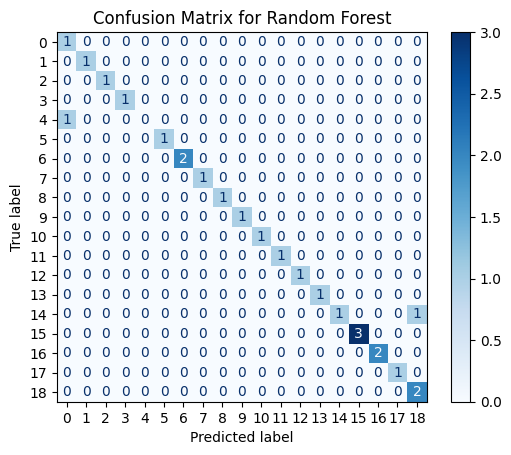

SVM Accuracy: 64.00%


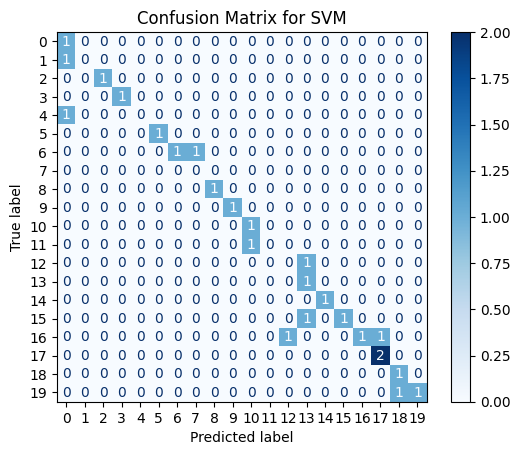

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:58:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 80.00%


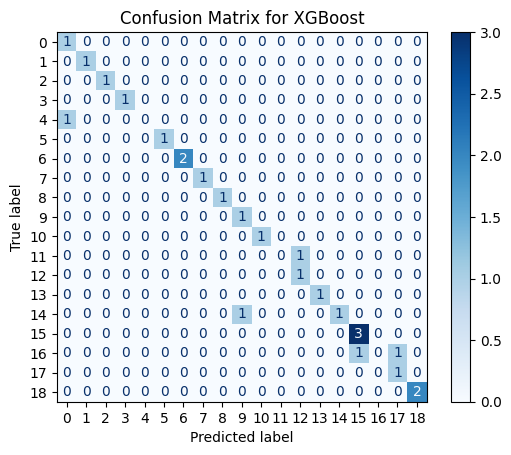

Gradient Boosting Accuracy: 76.00%


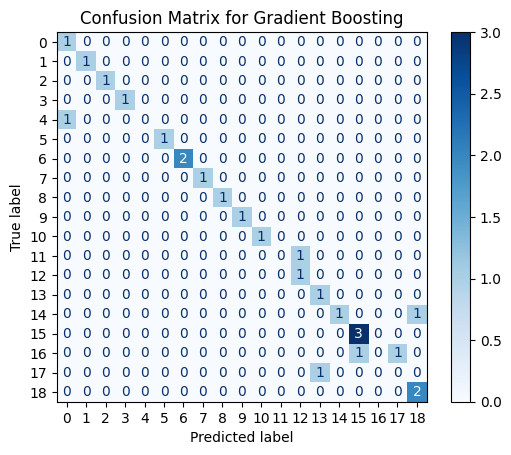

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Define the models to be evaluated
models = {
    'Random Forest': RandomForestClassifier(n_estimators=150, random_state=42),
    'SVM': SVC(kernel='rbf'),  # You can try different kernels like 'rbf'
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'Gradient Boosting':  GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy * 100:.2f}%')

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [ ]:
preds = models['SVM'].predict(X_test)
# preds_rev = np.argmax(preds, axis=1)
# y_test_rev = np.argmax(y_test, axis=1)
regions_pred = {}
for i in range(len(test_coors)):
    # regions_pred[test_coors[i]] = preds_rev[i]
    regions_pred[test_coors[i]] = preds[i]
    print(test_coors[i], '->', 'Pred:', preds[i], 'Actual:', y_test[i])

# Save dictionary
with open('/content/drive/MyDrive/SSL/SVMrbf.pkl', 'wb') as file:
    pickle.dump(regions_pred, file)
    print('Saved Dictionary.')

(0, 0, 0) -> Pred: 0 Actual: 0
(200, 20, 0) -> Pred: 2 Actual: 2
(100, 40, 0) -> Pred: 0 Actual: 1
(280, 60, 0) -> Pred: 3 Actual: 3
(40, 80, 0) -> Pred: 0 Actual: 4
(160, 100, 0) -> Pred: 6 Actual: 6
(80, 120, 0) -> Pred: 5 Actual: 5
(220, 140, 0) -> Pred: 7 Actual: 6
(20, 160, 0) -> Pred: 8 Actual: 8
(160, 180, 0) -> Pred: 10 Actual: 10
(120, 200, 0) -> Pred: 9 Actual: 9
(260, 220, 0) -> Pred: 10 Actual: 11
(60, 240, 0) -> Pred: 13 Actual: 12
(240, 260, 0) -> Pred: 13 Actual: 15
(180, 280, 0) -> Pred: 14 Actual: 14
(100, 300, 0) -> Pred: 13 Actual: 13
(280, 320, 0) -> Pred: 15 Actual: 15
(40, 340, 0) -> Pred: 16 Actual: 16
(260, 360, 0) -> Pred: 19 Actual: 19
(80, 380, 75) -> Pred: 17 Actual: 17
(220, 400, 0) -> Pred: 18 Actual: 19
(0, 340, 0) -> Pred: 12 Actual: 16
(140, 360, 75) -> Pred: 17 Actual: 17
(180, 380, 75) -> Pred: 18 Actual: 18
(20, 400, 0) -> Pred: 17 Actual: 16
Saved Dictionary.
